In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta
import math
!pip install pymc3
import pymc3 as pm
import arviz as az

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 7.6 MB/s 
     |████████████████████████████████| 1.8 MB 14.0 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=d5728f607ed2c869441549ece89a3556199de81a613d1e3ea11751974cb3854b
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


# Problem 1

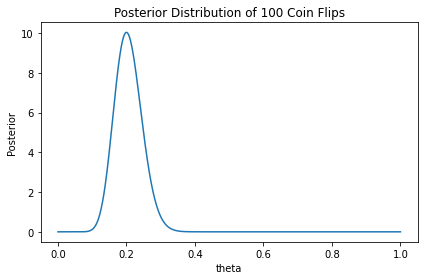

0.20020020020020018

In [13]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    #Calculate the sample of n tosses with probability p then uses the sample
    #to cacluate the likelihood
    sample = np.random.binomial(n, p)
    domain = np.linspace(0, 1, 1000)
    likelihood = binom.pmf(sample, n, domain)
    #Uses the likelihood from the sample to find the posterior and
    #uses the posterior to calculate the MAP
    post = likelihood / (sum(likelihood) * (domain[1] - domain[0]))
    map = np.argmax(post)

    #Plots the Posterior and returns the MAP estimate of p
    plt.plot(domain, post)
    plt.title(f'Posterior Distribution of {n} Coin Flips')
    plt.ylabel('Posterior')
    plt.xlabel('theta')
    plt.tight_layout()
    plt.show()

    return domain[map]

bernoulli_sampling(0.2, 100)


# Problem 2

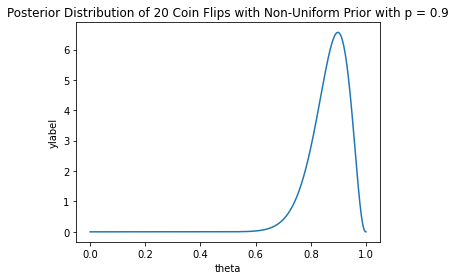

90%: 0.8978978978978979


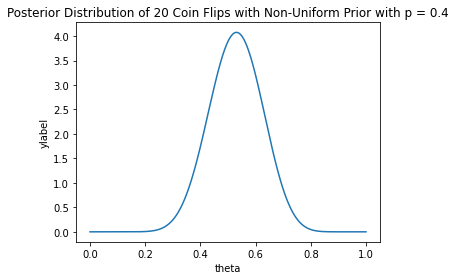

40%: 0.5305305305305306


In [25]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    #Calculate the sample of n tosses with probability p then uses the sample
    #to cacluate the likelihood
    sample = np.random.binomial(n, p)
    domain = np.linspace(0, 1, 1000)
    likelihood = binom.pmf(sample, n, domain) * prior.pdf(domain)
    #Uses the likelihood from the sample to find the posterior and
    #uses the posterior to calculate the MAP
    post = likelihood / (sum(likelihood) * (domain[1] - domain[0]))
    map = np.argmax(post)
    #Plots the Posterior and returns the MAP estimate of p
    plt.plot(domain, post)
    plt.title(f'Posterior Distribution of {n} Coin Flips with Non-Uniform Prior with p = {p}')
    plt.xlabel('theta')
    plt.ylabel('ylabel')
    plt.tight_layout()
    plt.show()

    return domain[map]

print('90%:', non_uniform_prior(0.9, 20, beta(5, 1.5)))
print('40%:', non_uniform_prior(0.4, 20, beta(5, 1.5)))


# Problem 3

In [26]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. Return a list of strings, not including the 0th day.
    """
    #Initializes the states and dictionary
    states = ['sun', 'rain', 'wind']
    dictionary = dict(zip(states, range(3)))

    #Steps through the columns to find the value returned at 1
    def _step(state):
      col = transition_matrix[:, dictionary[state]]
      return states[np.argmax(np.random.multinomial(1, col))]

    #Initializes the walk and the starting point
    walk = []
    start = 'sun'

    #Loops through and selects the weather of the next day based off the probabilities
    for i in range(days+1):
      walk.append(start)
      start = _step(start)

    return walk[1:]
    

In [35]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)
weather_forecast(transition_matrix)

['wind', 'wind', 'wind', 'wind', 'wind', 'wind', 'sun', 'sun', 'sun', 'wind']

# Problem 4

In [32]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Plot the trace plot and return the expected value of
    the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    #Initialize model
    model = pm.Model()
    with model:
        #Defines the prior as a beta distribution
        p = pm.Beta('p', alpha=1, beta=1)
        #Defines the likelihood as Bernoulli
        y = pm.Bernoulli('y', p=p, observed=data)
        #Sample from the posterior and plots the trace
        trace=pm.sample(n)
        az.plot_trace(trace)
        new_p = trace['p']
    return new_p.mean()


/usr/local/lib/python3.8/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


0.1863198050680694

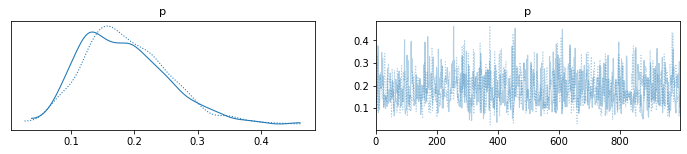

In [33]:
data = bernoulli.rvs(0.2, size=30)
posterior_sampling(data)

# Problem 5

In [38]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):
    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu, 1/tau) where mu has a prior of Normal(m, s), 
    and tau has a prior of Gamma(alpha, beta). Set up a PyMC3 model for this 
    situation and sample from the poterior n times. Plot the trace plots for 
    mu and tau, and return the expected value of the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    #Initialize model
    model = pm.Model()
    with model:
      #Defines tau using a gamma distribution
      tau = pm.Gamma('tau', alpha=alpha, beta=beta)
      #Defines mu and y as normal distributions
      mu =  pm.Normal('mu', mu=m, sigma=s)
      y = pm.Normal('y', mu=mu, sigma=1/tau, observed=observed_heights)
      #sample from the posterior and plots the trace
      trace= pm.sample(n)
      az.plot_trace(trace)
      new_p = trace['mu']
    return new_p.mean()
    

/usr/local/lib/python3.8/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


180.56943378247044

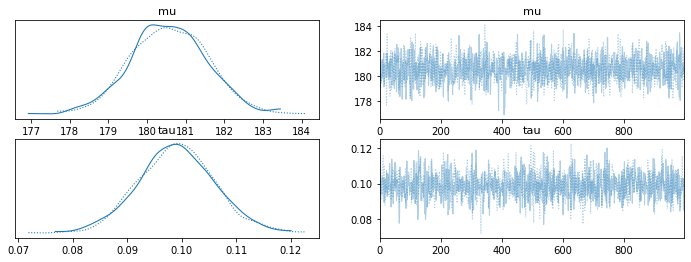

In [39]:
heights = np.random.normal(180,10,100)
height_model(heights)